# Crime classification in San Francisco

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.pyplot as plt
from functools import partial

try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'ML/CrimeSF'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/ML/CrimeSF


Import the pre-processing data

In [19]:
train_data= pd.read_csv('pre_processing_train_data.csv')
train_data=train_data.iloc[:,1:]

Select a sample to train faster

In [23]:
train_sample=train_data.sample(n=10000)
train_labels=train_sample['Category']
print("Nb class selecteb among the 39 possible : ",len(train_labels.unique()))
train_sample.drop('Category',inplace =True, axis=1)   # remove the label from the train sample
train_sample.head()

Nb class selecteb among the 39 possible :  38


,X,Y,Year,X_Bar_District,Y_Bar_District,Sin_Year,Cos_Year,Sin_Hour,Cos_Hour,Sin_Day_m,Cos_Day_m,Sin_Month,Cos_Month,Sin_Day_w,Cos_Day_w
350221,-122.414753,37.772924,0.166667,-122.405282,37.779915,6.327053e-01,-0.774393,7.071068e-01,-0.707107,0.571268,0.820763,-5.000000e-01,-0.866025,-0.974928,-0.222521
662220,-122.423772,37.776838,-0.666667,-122.426647,37.786379,-8.660254e-01,0.500000,-8.660254e-01,0.500000,-0.485302,-0.874347,-2.449294e-16,1.000000,-0.781831,0.623490
341079,-122.460310,37.785538,0.166667,-122.470087,37.780208,2.181489e-02,0.999762,0.000000e+00,1.000000,-0.937752,0.347305,-8.660254e-01,-0.500000,0.974928,-0.222521
709804,-122.429623,37.772156,-0.666667,-122.426647,37.786379,3.925982e-02,-0.999229,2.588190e-01,-0.965926,-0.968077,-0.250653,8.660254e-01,-0.500000,-0.433884,-0.900969
615036,-122.425111,37.804146,-0.500000,-122.409619,37.795685,-3.216245e-16,-1.000000,1.224647e-16,-1.000000,-0.998717,-0.050649,-8.660254e-01,-0.500000,0.974928,-0.222521


In [24]:
# Load the model, loss and useful function
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss


X=train_sample
y=train_labels


# Split the training test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Fit a Random Forest model
clf = RandomForestClassifier(n_estimators=150,max_depth=None,min_samples_leaf=100,max_features='sqrt',bootstrap=False,random_state=42)
clf.fit(X_train, y_train)
p_pred = clf.predict_proba(X_test)

print("The loss on the test set is : ",log_loss(y_test,p_pred,labels=y_train.unique()))


The loss on the test set is :  2.540480349070633


We want to make a cross validation on the random forest model. The main parameters are the number of estimators, the maximal depth and the minimum number of sample per leaf. We will first choose a number of estimators independently from the other parameters. Indeed, the increasing of the number of tree is not correlated with the depth of the trees. It just certify that the results are not too random. \\

For the other parameters, there are closely linked. One important point is that the training set is much bigger than the training sample used for cross validation. Thereby, a maximal depth which works well in cross validation could not work so well on the whole training set. Indeed, there will be much more example per leaf and the model will not be enough precise. The only choice of the minimum sample per leaf determined the depth of trees and permits to guarantee the performance of the model for any size of the training example. Indeed, for a number of sample $n$ and a depth $d$, the number of sample per leaf will roughly be $\frac{n}{2^d}$. Then if we fix this number, we fix the depth.

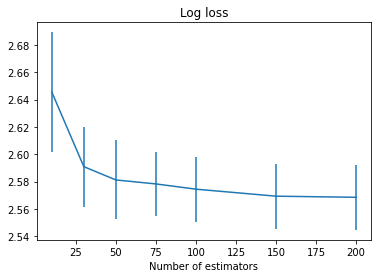

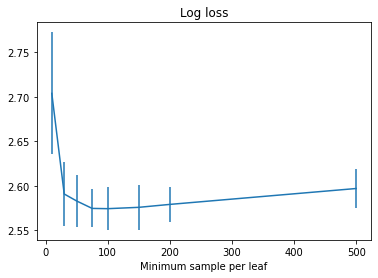

In [33]:
def cross_val_rdf_nb(X,y,nb_estimators=[10,50,100,150,200]):
    X=np.array(X)
    y=np.array(y)
    nb=len(nb_estimators)
    losses=[]
    for i in range(nb):
        loss=[]
        clf=RandomForestClassifier(n_estimators=nb_estimators[i],min_samples_leaf=100,random_state=42)
        for it in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y , random_state =it,     test_size=0.25)
            clf.fit(X_train,y_train)
            p_pred = clf.predict_proba(X_test)
            l=log_loss(y_test,p_pred,labels=np.unique(y_train))
            loss.append(l)
        losses.append(loss)
    losses=np.asarray(losses)
    plt.title("Log loss")
    plt.xlabel("Number of estimators")
    plt.errorbar(nb_estimators,losses.mean(axis=1),losses.std(axis=1))
    plt.show()

def cross_val_rdf_msl(X,y,msl_range=[10,50,100,200]):
    X=np.array(X)
    y=np.array(y)
    nb=len(msl_range)
    losses=[]
    for i in range(nb):
        loss=[]
        clf=RandomForestClassifier(n_estimators=100,min_samples_leaf=msl_range[i],random_state=42)
        for it in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y , random_state =it, test_size=0.25)
            clf.fit(X_train,y_train)
            p_pred = clf.predict_proba(X_test)
            l=log_loss(y_test,p_pred,labels=np.unique(y_train))
            loss.append(l)
        losses.append(loss)
    losses=np.asarray(losses)
    plt.title("Log loss")
    plt.xlabel("Minimum sample per leaf")
    plt.errorbar(msl_range,losses.mean(axis=1),losses.std(axis=1))
    plt.show()

cross_val_rdf_nb(X,y,nb_estimators=[10,30,50,75,100,150,200])
cross_val_rdf_msl(X,y,msl_range=[10,30,50,75,100,150,200,500])


We observe that a number of 150 estimators is a good tradeoff between precision and computation time and that a minimum sample per leaf of 100 is optimal for our problem. We can now fit our model on the full training set.

In [8]:
train_labels=train_data['Category']
train_data.drop('Category',inplace =True, axis=1)   # remove the label from the train sample

clf = RandomForestClassifier(n_estimators=150,min_samples_leaf=100)

clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Load the test dataset, with the categories of our training data.

In [9]:
test_data= pd.read_csv('pre_processing_test_data.csv')
test_data=test_data.iloc[:,1:]
list_cat=np.load('categories.npy',allow_pickle=True)
test_data.head()

,X,Y,Year,X_Bar_District,Y_Bar_District,Sin_Time,Cos_Time,Sin_Hour,Cos_Hour,Sin_Day_m,Cos_Day_m,Sin_Month,Cos_Month,Sin_Day_w,Cos_Day_w
0,-122.399588,37.735051,1.0,-122.393457,37.740094,-0.004363,0.999990,-0.258819,0.965926,0.897805,-0.440394,0.5,-0.866025,-0.781831,0.62349
1,-122.391523,37.732432,1.0,-122.393457,37.740094,-0.039260,0.999229,-0.258819,0.965926,0.897805,-0.440394,0.5,-0.866025,-0.781831,0.62349
2,-122.426002,37.792212,1.0,-122.426336,37.795198,-0.043619,0.999048,-0.258819,0.965926,0.897805,-0.440394,0.5,-0.866025,-0.781831,0.62349
3,-122.437394,37.721412,1.0,-122.428722,37.728411,-0.065403,0.997859,-0.258819,0.965926,0.897805,-0.440394,0.5,-0.866025,-0.781831,0.62349
4,-122.437394,37.721412,1.0,-122.428722,37.728411,-0.065403,0.997859,-0.258819,0.965926,0.897805,-0.440394,0.5,-0.866025,-0.781831,0.62349


Predict the probabilities for the test dataset and save them in a csv file.

In [16]:
p_pred = clf.predict_proba(test_data)
pred= pd.DataFrame (p_pred, columns = list_cat)
pred.to_csv("pred2.csv")
pred.head()s

(884262, 39)


This result gives us finally a score of 2.418, which rank us 500 on the 2500 teams in the competition.